In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

from pathlib import Path
from PIL import ImageDraw, ImageFont

# import fastai
# from fastai.vision import *
# from fastai.vision.all import *
# from fastai.vision.gan import *

In [8]:
data_dir = Path("/home/orelit/Projects -Sathsara/Planigo/data/bakery_splitted/folder5")

ds=ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])


label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
  label2id[class_name] = str(i)
  id2label[str(i)] = class_name

In [9]:
import json
with open('/home/orelit/Projects -Sathsara/Planigo/Models/Bakery/Bakery5/label2id_Bakery5.json', 'w') as fp:
    json.dump(label2id, fp)
    
with open('/home/orelit/Projects -Sathsara/Planigo/Models/Bakery/Bakery5/id2label_Bakery5.json', 'w') as fp:
    json.dump(id2label, fp)

In [10]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=32, 
   collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, 
   num_workers=2)
model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class Classifier(pl.LightningModule):
   def __init__(self, model, lr: float = 2e-5, **kwargs): 
       super().__init__()
       self.save_hyperparameters('lr', *list(kwargs))
       self.model = model
       self.forward = self.model.forward 
       self.val_acc = Accuracy()
   def training_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"train_loss", outputs.loss)
       return outputs.loss
   def validation_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"val_loss", outputs.loss)
       acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"val_acc", acc, prog_bar=True)
       return outputs.loss
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), 
                        lr=self.hparams.lr,weight_decay = 0.00025)

In [12]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=10)
trainer.fit(classifier, train_loader, val_loader)

model.save_pretrained("/home/orelit/Projects -Sathsara/Planigo/Models/Bakery/Bakery5/model")

Global seed set to 42
/home/orelit/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.674   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
def prediction(img_path):
   im=Image.open(img_path)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   outputs = model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   tensor_result = outputs.logits.softmax(1)
   prob = torch.max(tensor_result)
   new_result = result.tolist() 
   for i in new_result:
     return(id2label[str(i)])

# Model Testing - black


In [14]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [15]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290008804332
Real Label :  7290008804332
Correctly Classified
.....................................
Prediction :  7804414000860
Real Label :  7804414000860
Correctly Classified
.....................................
Prediction :  7290017589633
Real Label :  7290017589633
Correctly Classified
.....................................
Prediction :  7290008804189
Real Label :  7290008804189
Correctly Classified
.....................................
Prediction :  7290008802895
Real Label :  7290008802895
Correctly Classified
.....................................
Prediction :  7290101582366
Real Label :  7290101582366
Correctly Classified
.....................................
Prediction :  7290017589633
Real Label :  7290017589633
Correctly Classified
.....................................
Prediction :  7290017647425
Real Label :  7290017647425
Correctly Classified
.....................................
Prediction :  7804414000877
Real Label :  7804414000877
Correctly Classified
...

Prediction :  7290008670142
Real Label :  7290017589633
Misclassified
.....................................
Prediction :  7290017289175
Real Label :  7290017289175
Correctly Classified
.....................................
Prediction :  7290008802512
Real Label :  7290008802512
Correctly Classified
.....................................
Prediction :  7290008802512
Real Label :  7290008802512
Correctly Classified
.....................................
Prediction :  7290017589763
Real Label :  7290017589763
Correctly Classified
.....................................
Prediction :  7290008801010
Real Label :  7290008801010
Correctly Classified
.....................................
Prediction :  7804414000877
Real Label :  7804414000877
Correctly Classified
.....................................
Prediction :  7290008802895
Real Label :  7290008802895
Correctly Classified
.....................................
Prediction :  8422443005213
Real Label :  8422443005213
Correctly Classified
..........

Prediction :  7290017812052
Real Label :  7290017812052
Correctly Classified
.....................................
Prediction :  7290015781107
Real Label :  7290015781107
Correctly Classified
.....................................
Prediction :  7290017289120
Real Label :  7290017289120
Correctly Classified
.....................................
Prediction :  7290008804189
Real Label :  7290008804189
Correctly Classified
.....................................
Prediction :  7290017589763
Real Label :  7290017589763
Correctly Classified
.....................................
Prediction :  8002450206522
Real Label :  8002450206522
Correctly Classified
.....................................
Prediction :  7290015781091
Real Label :  7290015781091
Correctly Classified
.....................................
Prediction :  8002450206522
Real Label :  8002450206522
Correctly Classified
.....................................
Prediction :  7290016717235
Real Label :  7290016717235
Correctly Classified
...

Prediction :  7290017589848
Real Label :  7290017589848
Correctly Classified
.....................................
Prediction :  7290017289120
Real Label :  7290017289120
Correctly Classified
.....................................
Prediction :  7290016717235
Real Label :  7290016717235
Correctly Classified
.....................................
Prediction :  7290015781091
Real Label :  7290015781091
Correctly Classified
.....................................
Prediction :  7804414000860
Real Label :  7804414000860
Correctly Classified
.....................................
Prediction :  7290002363491
Real Label :  7290002363491
Correctly Classified
.....................................
Prediction :  7290017812052
Real Label :  7290017812052
Correctly Classified
.....................................
Prediction :  7290015781091
Real Label :  7290015781091
Correctly Classified
.....................................
Prediction :  7290017589633
Real Label :  7290017589633
Correctly Classified
...

Prediction :  7290015781299
Real Label :  7290015781299
Correctly Classified
.....................................
Prediction :  7290008803090
Real Label :  7290008803090
Correctly Classified
.....................................
Prediction :  7290008804189
Real Label :  7290008804189
Correctly Classified
.....................................
Prediction :  7290008805964
Real Label :  7290008805964
Correctly Classified
.....................................
Prediction :  7290008803090
Real Label :  7290008803090
Correctly Classified
.....................................
Prediction :  7290017589633
Real Label :  7290017589633
Correctly Classified
.....................................
Prediction :  7290018165294
Real Label :  7290018165294
Correctly Classified
.....................................
Prediction :  7290008670142
Real Label :  7290008670142
Correctly Classified
.....................................
Prediction :  7804414000860
Real Label :  7804414000860
Correctly Classified
...

Prediction :  7290015781299
Real Label :  7290015781299
Correctly Classified
.....................................
Prediction :  7290008803090
Real Label :  7290008803090
Correctly Classified
.....................................
Prediction :  7804414000877
Real Label :  7804414000877
Correctly Classified
.....................................
Prediction :  7290008804189
Real Label :  7290008804189
Correctly Classified
.....................................
Prediction :  7290008805520
Real Label :  7290008805520
Correctly Classified
.....................................
Prediction :  7290017589633
Real Label :  7290017589633
Correctly Classified
.....................................
Prediction :  7290008804332
Real Label :  7290008804332
Correctly Classified
.....................................
Prediction :  7290008670142
Real Label :  7290008670142
Correctly Classified
.....................................
Prediction :  7290008802291
Real Label :  7290008802291
Correctly Classified
...

# Model Testing - black red

In [7]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [8]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290016717099
Real Label :  7290016717099
Correctly Classified
.....................................
Prediction :  7290008801843
Real Label :  7290008801843
Correctly Classified
.....................................
Prediction :  7290000024264
Real Label :  7290000024264
Correctly Classified
.....................................
Prediction :  7290000023809
Real Label :  7290000023809
Correctly Classified
.....................................
Prediction :  7290015781015
Real Label :  7290015781015
Correctly Classified
.....................................
Prediction :  7290000024202
Real Label :  7290000024202
Correctly Classified
.....................................
Prediction :  7290018294208
Real Label :  7290018294208
Correctly Classified
.....................................
Prediction :  7290014503137
Real Label :  7290014503137
Correctly Classified
.....................................
Prediction :  7290018294208
Real Label :  7290014503137
Misclassified
..........

Prediction :  7290000024202
Real Label :  7290000024202
Correctly Classified
.....................................
Prediction :  7290018294208
Real Label :  7290000024264
Misclassified
.....................................
Prediction :  7290000024264
Real Label :  7290000024264
Correctly Classified
.....................................
Prediction :  7290000024264
Real Label :  7290000024264
Correctly Classified
.....................................
Prediction :  7290014466609
Real Label :  7290014466609
Correctly Classified
.....................................
Prediction :  7290000023809
Real Label :  7290000023809
Correctly Classified
.....................................
Prediction :  7290000023809
Real Label :  7290000023809
Correctly Classified
.....................................
Prediction :  7290014466609
Real Label :  7290014503137
Misclassified
.....................................
Prediction :  7290004494148
Real Label :  7290004494148
Correctly Classified
.................

Prediction :  7290018294208
Real Label :  7290014503137
Misclassified
.....................................
Prediction :  7290015781008
Real Label :  7290015781008
Correctly Classified
.....................................
Prediction :  7290015781008
Real Label :  7290015781008
Correctly Classified
.....................................
Prediction :  7290015781008
Real Label :  7290015781008
Correctly Classified
.....................................
Prediction :  7290018294208
Real Label :  7290018294208
Correctly Classified
.....................................
Prediction :  7290014503137
Real Label :  7290014503137
Correctly Classified
.....................................
Prediction :  7290018294208
Real Label :  7290018294208
Correctly Classified
.....................................
Prediction :  7290004494148
Real Label :  7290004494148
Correctly Classified
.....................................
Prediction :  7290015781008
Real Label :  7290015781008
Correctly Classified
..........

# Model Testing - black white

In [7]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [8]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290103681364
Real Label :  7290103681364
Correctly Classified
.....................................
Prediction :  7290108620115
Real Label :  7290108620115
Correctly Classified
.....................................
Prediction :  7290108620115
Real Label :  7290108620115
Correctly Classified
.....................................
Prediction :  7290008670302
Real Label :  7290008670302
Correctly Classified
.....................................
Prediction :  7290014466135
Real Label :  7290014466135
Correctly Classified
.....................................
Prediction :  7290103681364
Real Label :  7290103681364
Correctly Classified
.....................................
Prediction :  7290000521404
Real Label :  7290000521404
Correctly Classified
.....................................
Prediction :  7290000521008
Real Label :  7290000521008
Correctly Classified
.....................................
Prediction :  7290000521404
Real Label :  7290000521404
Correctly Classified
...

Prediction :  8002450206508
Real Label :  8002450206508
Correctly Classified
.....................................
Prediction :  7290103681371
Real Label :  7290103681371
Correctly Classified
.....................................
Prediction :  7290000521008
Real Label :  7290000521008
Correctly Classified
.....................................
Prediction :  7290000024554
Real Label :  7290000024554
Correctly Classified
.....................................
Prediction :  7290101582397
Real Label :  7290101582397
Correctly Classified
.....................................
Prediction :  7290014466135
Real Label :  7290014466135
Correctly Classified
.....................................
Prediction :  7290000521404
Real Label :  7290000521404
Correctly Classified
.....................................
Prediction :  7290101582397
Real Label :  7290101582397
Correctly Classified
.....................................
Prediction :  7290014466128
Real Label :  7290014466128
Correctly Classified
...

Prediction :  7290010173044
Real Label :  7290010173044
Correctly Classified
.....................................
Prediction :  7290015350136
Real Label :  7290015350136
Correctly Classified
.....................................
Prediction :  7290008670302
Real Label :  7290008670302
Correctly Classified
.....................................
Prediction :  7290008921329
Real Label :  7290008921329
Correctly Classified
.....................................
Prediction :  7290008801522
Real Label :  7290000521008
Misclassified
.....................................
Prediction :  7290101582397
Real Label :  7290101582397
Correctly Classified
.....................................
Prediction :  7290005966088
Real Label :  7290005966088
Correctly Classified
.....................................
Prediction :  7290103681364
Real Label :  7290103681364
Correctly Classified
.....................................
Prediction :  7290018165959
Real Label :  7290018165959
Correctly Classified
..........

Prediction :  7804414017134
Real Label :  7804414017134 (191).jpg
Misclassified
.....................................
Prediction :  7290018165959
Real Label :  7290018165959
Correctly Classified
.....................................
Prediction :  7290005966088
Real Label :  7290005966088
Correctly Classified
.....................................
Prediction :  7290017647548
Real Label :  7290017647548
Correctly Classified
.....................................
Prediction :  608614309269
Real Label :  608614309269
Correctly Classified
.....................................
Prediction :  7290014466128
Real Label :  7290014466128
Correctly Classified
.....................................
Prediction :  7290008670302
Real Label :  7290008670302
Correctly Classified
.....................................
Prediction :  7290014501942
Real Label :  7290014501942
Correctly Classified
.....................................
Prediction :  7290000024554
Real Label :  7290000024554
Correctly Classified
..

# Model Testing - green

In [14]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [15]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290000024240
Real Label :  7290000024240
Correctly Classified
.....................................
Prediction :  7290017812885
Real Label :  7290017812885
Correctly Classified
.....................................
Prediction :  7290004658946
Real Label :  7290004658946
Correctly Classified
.....................................
Prediction :  7290017812885
Real Label :  7290017812885
Correctly Classified
.....................................
Prediction :  7290004658946
Real Label :  7290004658946
Correctly Classified
.....................................
Prediction :  7804414000884
Real Label :  7804414000884
Correctly Classified
.....................................
Prediction :  7290000024516
Real Label :  7290000024516
Correctly Classified
.....................................
Prediction :  7290004658946
Real Label :  7290004658946
Correctly Classified
.....................................
Prediction :  7290004494353
Real Label :  7290004494353
Correctly Classified
...

Prediction :  7804414000884
Real Label :  7804414000884
Correctly Classified
.....................................
Prediction :  7290008921336
Real Label :  7290008921336
Correctly Classified
.....................................
Prediction :  608614309245
Real Label :  608614309245
Correctly Classified
.....................................
Prediction :  608614309276
Real Label :  608614309276
Correctly Classified
.....................................
Prediction :  7290004494315
Real Label :  7290004494315
Correctly Classified
.....................................
Prediction :  7290004658953
Real Label :  7290004658953
Correctly Classified
.....................................
Prediction :  7290103681388
Real Label :  7290103681388
Correctly Classified
.....................................
Prediction :  7290014501232
Real Label :  7290014501232
Correctly Classified
.....................................
Prediction :  7290008921336
Real Label :  7290008921336
Correctly Classified
.......

Prediction :  7290014501232
Real Label :  7290014501232
Correctly Classified
.....................................
Prediction :  608614309245
Real Label :  608614309245
Correctly Classified
.....................................
Prediction :  7290004494353
Real Label :  7290004494353
Correctly Classified
.....................................
Prediction :  7290017812885
Real Label :  7290017812885
Correctly Classified
.....................................
Prediction :  7804414000884
Real Label :  7804414000884
Correctly Classified
.....................................
Prediction :  7290103681388
Real Label :  7290103681388
Correctly Classified
.....................................
Prediction :  7290103681388
Real Label :  7290103681388
Correctly Classified
.....................................
Prediction :  7290014501232
Real Label :  7290014501232
Correctly Classified
.....................................
Prediction :  7290004658953
Real Label :  7290004658953
Correctly Classified
.....

# Model Testing - light_brown

In [22]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [23]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  4022025001905
Real Label :  4022025001905
Correctly Classified
.....................................
Prediction :  5998623530644
Real Label :  5998623530644
Correctly Classified
.....................................
Prediction :  7290017812588
Real Label :  7290017812588
Correctly Classified
.....................................
Prediction :  7290017812618
Real Label :  7290017812618
Correctly Classified
.....................................
Prediction :  7290018165560
Real Label :  7290018165560
Correctly Classified
.....................................
Prediction :  7290008804455
Real Label :  7290008804455
Correctly Classified
.....................................
Prediction :  4022025002100
Real Label :  4022025002100
Correctly Classified
.....................................
Prediction :  7290010656615
Real Label :  7290010656615
Correctly Classified
.....................................
Prediction :  7290018165560
Real Label :  7290018165560
Correctly Classified
...

Prediction :  7290000024523
Real Label :  7290000024523
Correctly Classified
.....................................
Prediction :  4022025290408
Real Label :  4022025290408
Correctly Classified
.....................................
Prediction :  7290015951869
Real Label :  7290015951869
Correctly Classified
.....................................
Prediction :  3760125946719
Real Label :  3760125946719
Correctly Classified
.....................................
Prediction :  3760125946719
Real Label :  3760125946719
Correctly Classified
.....................................
Prediction :  7290000024523
Real Label :  7290000024523
Correctly Classified
.....................................
Prediction :  4022025290408
Real Label :  4022025290408
Correctly Classified
.....................................
Prediction :  7290015350402
Real Label :  7290015350402
Correctly Classified
.....................................
Prediction :  7290006696717
Real Label :  7290006696717
Correctly Classified
...

Prediction :  7290017812830
Real Label :  7290017812830
Correctly Classified
.....................................
Prediction :  5998623530644
Real Label :  5998623530644
Correctly Classified
.....................................
Prediction :  7290017812588
Real Label :  7290017812588
Correctly Classified
.....................................
Prediction :  4022025001905
Real Label :  4022025001905
Correctly Classified
.....................................
Prediction :  7290006696717
Real Label :  7290006696717
Correctly Classified
.....................................
Prediction :  7290006696717
Real Label :  7290006696717
Correctly Classified
.....................................
Prediction :  4022025001905
Real Label :  4022025001905
Correctly Classified
.....................................
Prediction :  7290016717051
Real Label :  7290016717051
Correctly Classified
.....................................
Prediction :  7290017812830
Real Label :  7290017812830
Correctly Classified
...

# Model Testing - light_yellow

In [7]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [8]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290108620214
Real Label :  7290108620214
Correctly Classified
.....................................
Prediction :  7798141877829
Real Label :  7798141877829
Correctly Classified
.....................................
Prediction :  7290014466463
Real Label :  7290014466463
Correctly Classified
.....................................
Prediction :  7290017289199
Real Label :  7290017289199
Correctly Classified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  7290008804462
Real Label :  7290008804462
Correctly Classified
.....................................
Prediction :  7290008803014
Real Label :  7290008803014
Correctly Classified
.....................................
Prediction :  7290008802529
Real Label :  7290008802529
Correctly Classified
.....................................
Prediction :  7290017289182
Real Label :  7290017289182
Correctly Classified
.....

Prediction :  7798141877829
Real Label :  7798141877829
Correctly Classified
.....................................
Prediction :  7290008802529
Real Label :  7290008801546
Misclassified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  7798141877829
Real Label :  7798141877829
Correctly Classified
.....................................
Prediction :  7290017289182
Real Label :  7290017289182
Correctly Classified
.....................................
Prediction :  7290008836265
Real Label :  7290008836265
Correctly Classified
.....................................
Prediction :  7290005966033
Real Label :  7290005966033
Correctly Classified
.....................................
Prediction :  7290008803014
Real Label :  7290008803014
Correctly Classified
.....................................
Prediction :  7290014256637
Real Label :  7290014256637
Correctly Classified
............

Prediction :  7290008803014
Real Label :  7290008803014
Correctly Classified
.....................................
Prediction :  7290017289182
Real Label :  7290017289182
Correctly Classified
.....................................
Prediction :  7290008802529
Real Label :  7290008801546
Misclassified
.....................................
Prediction :  7290017812847
Real Label :  7290017812847
Correctly Classified
.....................................
Prediction :  7290008804462
Real Label :  7290008804462
Correctly Classified
.....................................
Prediction :  7290008803014
Real Label :  7290008803014
Correctly Classified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  7798141877829
Real Label :  7798141877829
Correctly Classified
.....................................
Prediction :  7290017812847
Real Label :  7290017812847
Correctly Classified
............

# Model Testing - other

In [7]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [8]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290000023847
Real Label :  7290000023816
Misclassified
.....................................
Prediction :  7290008670159
Real Label :  7290008670159
Correctly Classified
.....................................
Prediction :  7290008801850
Real Label :  8002450204009
Misclassified
.....................................
Prediction :  7290018294000
Real Label :  7290004494919
Misclassified
.....................................
Prediction :  7290012576423
Real Label :  7290012576423
Correctly Classified
.....................................
Prediction :  7290000023847
Real Label :  7290014503144
Misclassified
.....................................
Prediction :  7290014503144
Real Label :  7290014503144
Correctly Classified
.....................................
Prediction :  7290004494377
Real Label :  7290004494377
Correctly Classified
.....................................
Prediction :  7290014503144
Real Label :  7290014503144
Correctly Classified
...............................

Prediction :  7290000023847
Real Label :  7290017589565
Misclassified
.....................................
Prediction :  7290000521022
Real Label :  7290000521022
Correctly Classified
.....................................
Prediction :  7290012576607
Real Label :  7290012576607
Correctly Classified
.....................................
Prediction :  7290006256775
Real Label :  7290006256775
Correctly Classified
.....................................
Prediction :  7290000023816
Real Label :  7290004494049
Misclassified
.....................................
Prediction :  7290014503144
Real Label :  7290014503144
Correctly Classified
.....................................
Prediction :  7290000023816
Real Label :  7290000023816
Correctly Classified
.....................................
Prediction :  7290000023847
Real Label :  7290000024530
Misclassified
.....................................
Prediction :  7290008801850
Real Label :  7290008801850
Correctly Classified
........................

Prediction :  7290017589923
Real Label :  7290017589923
Correctly Classified
.....................................
Prediction :  7290016717754
Real Label :  7290016717754
Correctly Classified
.....................................
Prediction :  7290012576423
Real Label :  7290012576423
Correctly Classified
.....................................
Prediction :  7290017812663
Real Label :  8002450204009
Misclassified
.....................................
Prediction :  7290016717754
Real Label :  7290016717754
Correctly Classified
.....................................
Prediction :  7290015350143
Real Label :  7290006256089
Misclassified
.....................................
Prediction :  7290017289106
Real Label :  7290017289106
Correctly Classified
.....................................
Prediction :  7290000024530
Real Label :  7290000024530
Correctly Classified
.....................................
Prediction :  7290103681395
Real Label :  7290103681395
Correctly Classified
.................

Prediction :  073490154317
Real Label :  073490154317
Correctly Classified
.....................................
Prediction :  7290000024530
Real Label :  7290000024530
Correctly Classified
.....................................
Prediction :  7290006256089
Real Label :  7290006256089
Correctly Classified
.....................................
Prediction :  7290101582373
Real Label :  7290101582373
Correctly Classified
.....................................
Prediction :  7290017289168
Real Label :  7290017289168
Correctly Classified
.....................................
Prediction :  7290015781145
Real Label :  7290017289205
Misclassified
.....................................
Prediction :  7290014503144
Real Label :  7290014503144
Correctly Classified
.....................................
Prediction :  8412168002529
Real Label :  8412168002529
Correctly Classified
.....................................
Prediction :  7290000023816
Real Label :  7290000023816
Correctly Classified
............

Prediction :  7290017004457
Real Label :  7290017004457
Correctly Classified
.....................................
Prediction :  7290017289106
Real Label :  7290017289106
Correctly Classified
.....................................
Prediction :  7290008670159
Real Label :  7290008670159
Correctly Classified
.....................................
Prediction :  7290103681630
Real Label :  7290103681630
Correctly Classified
.....................................
Prediction :  7290000023847
Real Label :  7290000023847
Correctly Classified
.....................................
Prediction :  7290015350143
Real Label :  7290015350143
Correctly Classified
.....................................
Prediction :  7290004494919
Real Label :  7290004494919
Correctly Classified
.....................................
Prediction :  7290000521022
Real Label :  7290000521022
Correctly Classified
.....................................
Prediction :  7290008801850
Real Label :  7290008801850
Correctly Classified
...

Prediction :  7290004494049
Real Label :  7290004494049
Correctly Classified
.....................................
Prediction :  7804414012368
Real Label :  7804414012368
Correctly Classified
.....................................
Prediction :  7290000023816
Real Label :  7290000023816
Correctly Classified
.....................................
Prediction :  7290017289205
Real Label :  7290017289205
Correctly Classified
.....................................
Prediction :  7290100944462
Real Label :  7290100944462
Correctly Classified
.....................................
Prediction :  7290103681180
Real Label :  7290103681180
Correctly Classified
.....................................
Prediction :  7290015781145
Real Label :  7290015781145
Correctly Classified
.....................................
Prediction :  7290015350143
Real Label :  7290015350143
Correctly Classified
.....................................
Prediction :  7290017589923
Real Label :  7290017589923
Correctly Classified
...

Prediction :  7290012576607
Real Label :  7290012576607
Correctly Classified
.....................................
Prediction :  7290108620092
Real Label :  7290108620092
Correctly Classified
.....................................
Prediction :  7290103681180
Real Label :  7290103681180
Correctly Classified
.....................................
Prediction :  7290000023847
Real Label :  7290012576614
Misclassified
.....................................
Prediction :  7290017289205
Real Label :  7290015781121
Misclassified
.....................................
Prediction :  7290000023816
Real Label :  7290000023816
Correctly Classified
.....................................
Prediction :  7290017812663
Real Label :  7290017812663
Correctly Classified
.....................................
Prediction :  7290017812663
Real Label :  7290017812663
Correctly Classified
.....................................
Prediction :  073490154317
Real Label :  073490154317
Correctly Classified
...................

Prediction :  7290008670159
Real Label :  7290008670159
Correctly Classified
.....................................
Prediction :  7290000521022
Real Label :  7290000521022
Correctly Classified
.....................................
Prediction :  7290017589565
Real Label :  7290017589565
Correctly Classified
.....................................
Prediction :  7290101582373
Real Label :  7290101582373
Correctly Classified
.....................................
Prediction :  7290017812663
Real Label :  7290017812663
Correctly Classified
.....................................
Prediction :  7290017289205
Real Label :  7290017289205
Correctly Classified
.....................................
Prediction :  7290008836494
Real Label :  7290008836494
Correctly Classified
.....................................
Prediction :  7290103681395
Real Label :  7290103681395
Correctly Classified
.....................................
Prediction :  7290012576614
Real Label :  7290012576614
Correctly Classified
...

Prediction :  7290017004457
Real Label :  7290017004457
Correctly Classified
.....................................
Prediction :  7290015781121
Real Label :  7290015781121
Correctly Classified
.....................................
Prediction :  7290103681630
Real Label :  7290103681630
Correctly Classified
.....................................
Prediction :  7290017289106
Real Label :  7290017289106
Correctly Classified
.....................................
Prediction :  7290017289168
Real Label :  7290017289168
Correctly Classified
.....................................
Prediction :  7290017589923
Real Label :  7290017589923
Correctly Classified
.....................................
Prediction :  7290006256775
Real Label :  7290006256775
Correctly Classified
.....................................
Prediction :  7290008836494
Real Label :  7290008836494
Correctly Classified
.....................................
Prediction :  7290018294000
Real Label :  7290015348423
Misclassified
..........

# Model Testing - red

In [15]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_tests'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [16]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290008836272
Real Label :  7290008836272
Correctly Classified
.....................................
Prediction :  7290008836401
Real Label :  7290008836401
Correctly Classified
.....................................
Prediction :  7290010173037
Real Label :  7290010173037
Correctly Classified
.....................................
Prediction :  7290008836401
Real Label :  7290008836401
Correctly Classified
.....................................
Prediction :  7290008801461
Real Label :  7290008801461
Correctly Classified
.....................................
Prediction :  7290008801539
Real Label :  7290008801539
Correctly Classified
.....................................
Prediction :  7290017812571
Real Label :  7290017812571
Correctly Classified
.....................................
Prediction :  7290017812571
Real Label :  7290017812571
Correctly Classified
.....................................
Prediction :  7290014256620
Real Label :  7290014256620
Correctly Classified
...

Prediction :  7290008836401
Real Label :  7290008836401
Correctly Classified
.....................................
Prediction :  7290008801461
Real Label :  7290008801461
Correctly Classified
.....................................
Prediction :  7290008836425
Real Label :  7290008836425
Correctly Classified
.....................................
Prediction :  7290008836272
Real Label :  7290008836272
Correctly Classified
.....................................
Prediction :  7290017812571
Real Label :  7290017812571
Correctly Classified
.....................................
Prediction :  7290008836425
Real Label :  7290008836425
Correctly Classified
.....................................
Prediction :  7290015348379
Real Label :  8002450206003
Misclassified
.....................................
Prediction :  7290008803021
Real Label :  7290008803021
Correctly Classified
.....................................
Prediction :  7290008801461
Real Label :  7290008801461
Correctly Classified
..........

# Model Testing - white_and_blue

In [27]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/intermediate_data'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [29]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    splitted = image.split('_')
    real_class = splitted[1]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

Prediction :  7290017812847
Real Label :  8002450208007
Misclassified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  7290000484747
Real Label :  7290000484747
Correctly Classified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  7290017812847
Real Label :  8002450208007
Misclassified
.....................................
Prediction :  7290016717631
Real Label :  7290016717631
Correctly Classified
.....................................
Prediction :  4022025261002
Real Label :  4022025261002
Correctly Classified
.....................................
Prediction :  7290000484747
Real Label :  7290000484747
Correctly Classified
.......................

Prediction :  4022025261002
Real Label :  4022025261002
Correctly Classified
.....................................
Prediction :  608614309160
Real Label :  8002450208007
Misclassified
.....................................
Prediction :  608614309160
Real Label :  608614309160
Correctly Classified
.....................................
Prediction :  4001432773230
Real Label :  4001432773230
Correctly Classified
.....................................
Prediction :  7290016717631
Real Label :  7290016717631
Correctly Classified
.....................................
Prediction :  7290017812847
Real Label :  7290017812847
Correctly Classified
.....................................
Prediction :  4001432773230
Real Label :  4001432773230
Correctly Classified
.....................................
Prediction :  4022025001929
Real Label :  4022025001929
Correctly Classified
.....................................
Prediction :  4001432773230
Real Label :  4001432773230
Correctly Classified
.............

# Model inferencing with multiple models

In [3]:
import pandas as pd
import json

model_names = ['black1','black2','black3','black4','black_red1','black_red2','black_red3','black_white1',
               'black_white2','black_white3','green1','green2','light_brown1','light_brown2','light_yellow1',
               'light_yellow2','other','red','white_and_blue']

data_dict = {}
for model_name in model_names:
    with open("/home/orelit/Projects -Sathsara/Planigo/Models/WINE_POLYGON2/id2label_{}.json"
                   .format(model_name), 'r') as fcc_file:
        data = json.load(fcc_file)
        
        data_dict["list_{}".format(model_name)] = []

        for key in data.keys():
            
            data_dict["list_{}".format(model_name)].append(data[key])
            
    
#     content = my_file.read()
#     x = content.split('\n')
#     new_list = []
#     for item in x:
#         try:
#             new_item = int(item)
#             new_str = str(new_item)
#             new_list.append(new_str)
#         except:
#             pass
#     model_lists.append(new_list)
    
# model_lists[0]

# model_dict = {'model1':model_lists[0],'model2':model_lists[1],'model3':model_lists[2],'model4':model_lists[3],
#               'model5':model_lists[4],'model6':model_lists[5],'model7':model_lists[6],'model8':model_lists[7],
#               'model9':model_lists[8],'model10':model_lists[9],'model11':model_lists[10],'model12':model_lists[11]}



In [4]:
df = pd.DataFrame.from_dict(data_dict, orient='index').T
df

,list_black1,list_black2,list_black3,list_black4,list_black_red1,list_black_red2,list_black_red3,list_black_white1,list_black_white2,list_black_white3,list_green1,list_green2,list_light_brown1,list_light_brown2,list_light_yellow1,list_light_yellow2,list_other,list_red,list_white_and_blue
0,7290002363491,7290006256102,7290008802512,7290008801010,7290000023809,7290000024202,7290000521329,608614309269,608614309290,5998623530637,3120581456267,608614309276,4022025002100,3760125946719,608614309160,7290005966033,073490154317,7290008801461,4001432773230
1,7290004494063,7290008670142,7290008804332,7290008805964,7290000024264,7290000521404,7290000521350,7290000024554,7290008921459,7290008921299,5998623530620,7290000024516,4022025290408,4022025001905,7290008801546,7290008802529,7290000023816,7290008801539,4022025001929
2,7290004494131,7290008802291,7290015781107,7290008807777,7290000521008,7290004494148,7290005966088,7290008801522,7290014466128,7290008921329,608614309245,7290004494315,7290000024523,5998623530644,7290008803014,7290008807029,7290000023847,7290008803021,4022025261002
3,7290008802895,7290008804189,7290017289175,7290012576362,7290008801843,7290008670302,7290008670678,7290010173044,7290014501942,7290014466135,7290000024240,7290004494353,7290008670012,7290006696717,7290008804462,7290008836265,7290000024219,7290008836272,4603400000043
4,7290008803090,7290008805520,7290017289595,7290015781091,7290014503137,7290008801157,7290008921176,7290014501829,None,7290015350136,7290000521428,7290004658953,7290008804455,7290015781268,7290008921718,7290015781046,7290000024530,7290008836401,608614309160
5,7290017289588,7290016717235,7290017589763,7290015781299,7290015781008,7290014466609,7290101582397,7290017647548,None,7290018165959,7290004658946,7290008921336,7290010656615,7290016717051,7290010955619,7290017289199,7290000521022,7290008836425,7290000484747
6,7804414000877,7290017647425,7290017589848,7290017289120,7290015951227,7290015350150,7290103681364,7290103681197,None,7290103681371,7290012576348,7290014501232,7290015350402,7290017812618,7290014256637,7290017812069,7290004494049,7290010173037,7290005966033
7,7804414017141,7290101582366,7290017812052,7290017589633,7290018294208,7290015781015,7804414001621,7290108620115,None,None,7290015781138,7290014501331,7290015951869,7290018165560,7290014466463,7290017812977,7290004494377,7290014256620,7290014910461
8,8422443005213,7290101582403,7290108620108,7290018165294,7290108620177,7290016717099,7804414017134,None,None,None,7290017289601,7290015781220,7290017812588,None,7290017289182,7290108620214,7290004494919,7290015348379,7290016717631
9,None,7290103681173,7804414001614,7290018294192,8002450206508,7290103681401,None,None,None,None,7290017812885,7290017647708,7290017812830,None,7290017647722,7804414012344,7290006256089,7290017812571,7290017812847


In [5]:
import os
import matplotlib
import shutil

test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/Wine_test'

folder_names = []
for folder in os.listdir(test_data_path):
    folder_names.append(folder)

In [5]:
# for folder in folder_names:
#     for image_name in os.listdir(test_data_path+'/'+folder):
#         print('image name : ',image_name)
#         img = test_data_path+'/'+folder +'/'+image_name
#         print(img)
#         image = cv2.imread(img,flags=cv2.IMREAD_UNCHANGED)
#         RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
#         RGB_image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2RGB)
        
#         im = Image.fromarray(RGB_image_sharp)
#         im.save('/home/orelit/Projects -Sathsara/Planigo/data/temp/{}'.format(image_name))
        
#         if not os.path.exists('/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2_test/{}'.format(folder)):
#             os.makedirs('/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2_test/{}'.format(folder))
        
#         shutil.copy('/home/orelit/Projects -Sathsara/Planigo/data/temp/{}'.format(image_name), 
#                    '/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2_test/{}'.format(folder))

In [6]:
# import os
# import matplotlib
# import shutil

# test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2_test'

# folder_names = []
# for folder in os.listdir(test_data_path):
#     folder_names.append(folder)

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [7]:
def prediction(img_path,wine_model):
   im=Image.open(img_path)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   outputs = wine_model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   tensor_result = outputs.logits.softmax(1)
   prob = torch.max(tensor_result)
   new_result = result.tolist() 
   for i in new_result:
     return(id2label[str(i)])

In [12]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image, UnidentifiedImageError
import torch


test_results = {}
result_counts = {}
model_list = []
folder_image_counts = []
folder_correct_counts = []

count = 0
correct = 0
for folder in folder_names:
    prediction_list = []
    print('folder name :',folder)
    for column in df.columns:
        if folder  in df[column].unique():
            model  = column
    print('model name :',model)
    
    model_name = model[5:]
    print(model_name)
    
    data_dir = Path("/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2/{}".
                    format(model_name))
    print(data_dir)
    ds=ImageFolder(data_dir)
    
    label2id = {}
    id2label = {}
    for i, class_name in enumerate(ds.classes):
        label2id[class_name] = str(i)
        id2label[str(i)] = class_name
        
    model_path = '/home/orelit/Projects -Sathsara/Planigo/Models/WINE_POLYGON2/{}'.format(model_name)
    wine_model = ViTForImageClassification.from_pretrained(
         model_path,
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)
    folder_correct_count = 0
    folder_image_count = 0
    for image in os.listdir(test_data_path+'/'+folder):
        print('image name : ',image)
        img = test_data_path+'/'+folder +'/'+image
        pred= prediction(img,wine_model)
        print("predicted label : ",pred)
        test_label = image[image.rfind('/')+1:]
        real_class = test_label[0:13]
        print('real label : ',real_class)
        folder_image_count = folder_image_count +1
        if real_class == pred:
            correct = correct +1
            folder_correct_count = folder_correct_count +1
            print("Correctly classified")
            prediction_list.append('Correctly Classified')
        else:
            prediction_list.append(pred)
        count = count + 1
        print('..........................................')
        
    model_list.append(model[5:])
    folder_correct_counts.append(folder_correct_count)
    folder_image_counts.append(folder_image_count)
        
        
    print(prediction_list)
    test_results[folder] = prediction_list
#     result_counts[folder] = folder_result

acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)
print(test_results)

folder name : 7290017589633
model name : list_black4
black4
/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2/black4
image name :  7290017589633 (2).jpeg
predicted label :  7290017589633
real label :  7290017589633
Correctly classified
..........................................
image name :  7290017589633 (1).jpeg
predicted label :  7290017589633
real label :  7290017589633
Correctly classified
..........................................
image name :  7290017589633 (9).jpeg
predicted label :  7290017589633
real label :  7290017589633
Correctly classified
..........................................
image name :  7290017589633 (6).jpeg
predicted label :  7290017589633
real label :  7290017589633
Correctly classified
..........................................
image name :  7290017589633 (8).jpeg
predicted label :  7290017589633
real label :  7290017589633
Correctly classified
..........................................
image name :  7290017589633 (5).jpeg
predicted label :  729

image name :  7290000023816 (4).jpeg
predicted label :  7290004494919
real label :  7290000023816
..........................................
image name :  7290000023816 (7).jpeg
predicted label :  7290018294000
real label :  7290000023816
..........................................
image name :  7290000023816 (16).jpeg
predicted label :  7290000023847
real label :  7290000023816
..........................................
image name :  7290000023816 (3).jpeg
predicted label :  7290004494919
real label :  7290000023816
..........................................
image name :  7290000023816 (12).jpeg
predicted label :  7290018294000
real label :  7290000023816
..........................................
image name :  7290000023816 (15).jpeg
predicted label :  7290018294000
real label :  7290000023816
..........................................
image name :  7290000023816 (2).jpeg
predicted label :  7290004494919
real label :  7290000023816
..........................................
image name

predicted label :  7290017812588
real label :  7290000024523
..........................................
image name :  7290000024523 (39).jpeg
predicted label :  7290017812588
real label :  7290000024523
..........................................
image name :  7290000024523 (26).jpeg
predicted label :  7290017812588
real label :  7290000024523
..........................................
image name :  7290000024523 (31).jpeg
predicted label :  7290000024523
real label :  7290000024523
Correctly classified
..........................................
image name :  7290000024523 (25).jpeg
predicted label :  7290017812588
real label :  7290000024523
..........................................
image name :  7290000024523 (16).jpeg
predicted label :  7290000024523
real label :  7290000024523
Correctly classified
..........................................
image name :  7290000024523 (15).jpeg
predicted label :  7290017812588
real label :  7290000024523
..........................................
im

predicted label :  7290016717099
real label :  7290008801157
..........................................
image name :  7290008801157 (12).jpeg
predicted label :  7290103681401
real label :  7290008801157
..........................................
image name :  7290008801157 (9).jpeg
predicted label :  7290008670302
real label :  7290008801157
..........................................
image name :  7290008801157 (6).jpeg
predicted label :  7290008670302
real label :  7290008801157
..........................................
image name :  7290008801157 (10).jpeg
predicted label :  7290103681401
real label :  7290008801157
..........................................
image name :  7290008801157 (4).jpeg
predicted label :  7290008670302
real label :  7290008801157
..........................................
image name :  7290008801157 (3).jpeg
predicted label :  7290103681401
real label :  7290008801157
..........................................
image name :  7290008801157 (15).jpeg
predicted 

In [13]:
results_df = pd.DataFrame.from_dict(test_results, orient='index').T

In [14]:
results_df.fillna("",inplace=True)
results_df

,7290017589633,01790302,7290008805520,7290008804189,7290008802291,7290000023816,7290008802512,7290008805964,7290017589565,7290018294208,7290000024523,7290014256637,7290008801843,7290000023809,7290016717099,7290008801157
0,Correctly Classified,7290018294192,Correctly Classified,Correctly Classified,Correctly Classified,7290004494919,Correctly Classified,Correctly Classified,8002450201008,Correctly Classified,Correctly Classified,Correctly Classified,7290018294208,Correctly Classified,Correctly Classified,7290103681401
1,Correctly Classified,,Correctly Classified,Correctly Classified,7804414000860,7290018294000,Correctly Classified,Correctly Classified,,Correctly Classified,7290017812588,,,Correctly Classified,Correctly Classified,7290016717099
2,Correctly Classified,,7290108620153,7290008670142,Correctly Classified,7290000023847,Correctly Classified,,,Correctly Classified,7290017812588,,,Correctly Classified,,7290103681401
3,Correctly Classified,,Correctly Classified,Correctly Classified,7290103681173,7290004494919,,,,Correctly Classified,7290008670012,,,Correctly Classified,,7290008670302
4,Correctly Classified,,7290108620153,,Correctly Classified,7290018294000,,,,,7290008670012,,,Correctly Classified,,7290008670302
5,7290012576362,,Correctly Classified,,Correctly Classified,7290018294000,,,,,7290008670012,,,Correctly Classified,,7290103681401
6,Correctly Classified,,7290108620153,,7290008804189,7290004494919,,,,,Correctly Classified,,,7290000024264,,7290008670302
7,Correctly Classified,,Correctly Classified,,Correctly Classified,7290018294000,,,,,Correctly Classified,,,7290000024264,,7290103681401
8,Correctly Classified,,Correctly Classified,,,7290000023847,,,,,Correctly Classified,,,Correctly Classified,,7290103681401
9,Correctly Classified,,Correctly Classified,,,7290018294000,,,,,7290017812588,,,7290000024264,,7290000024202


In [45]:
results_df.to_csv('/home/orelit/Projects -Sathsara/Planigo/Test results/Wine/Batch 1 - AI floor wine 1,2,3/results.csv')

In [15]:
folder_image_counts

[11, 1, 18, 4, 8, 16, 3, 2, 1, 4, 41, 1, 1, 18, 2, 15]

In [16]:
result_counts = pd.DataFrame(list(zip(folder_names, model_list,folder_image_counts,folder_correct_counts)),
               columns =['folder_names', 'model_list','folder_image_count','folder_correct_count'])
result_counts

,folder_names,model_list,folder_image_count,folder_correct_count
0,7290017589633,black4,11,10
1,01790302,black4,1,0
2,7290008805520,black2,18,13
3,7290008804189,black2,4,3
4,7290008802291,black2,8,5
5,7290000023816,other,16,0
6,7290008802512,black3,3,3
7,7290008805964,black4,2,2
8,7290017589565,other,1,0
9,7290018294208,black_red1,4,4


In [17]:
incorrect_list = []
for i,row in enumerate(result_counts['folder_names']):
    incorrect = result_counts['folder_image_count'][i] - result_counts['folder_correct_count'][i]
    incorrect_list.append(incorrect )
    
incorrect_list

[1, 1, 5, 1, 3, 16, 0, 0, 1, 0, 25, 0, 1, 3, 0, 15]

In [18]:
result_counts['incorrectly classified'] = incorrect_list
result_counts

,folder_names,model_list,folder_image_count,folder_correct_count,incorrectly classified
0,7290017589633,black4,11,10,1
1,01790302,black4,1,0,1
2,7290008805520,black2,18,13,5
3,7290008804189,black2,4,3,1
4,7290008802291,black2,8,5,3
5,7290000023816,other,16,0,16
6,7290008802512,black3,3,3,0
7,7290008805964,black4,2,2,0
8,7290017589565,other,1,0,1
9,7290018294208,black_red1,4,4,0


In [19]:
result_counts.to_csv('/home/orelit/Projects -Sathsara/Planigo/Test results/Wine/Batch 1 - AI floor wine 1,2,3/result_counts.csv')

In [60]:
data_dir = '/home/orelit/Projects -Sathsara/Planigo/data/WINE_POLYGON_VIT_2'

<AxesSubplot:>

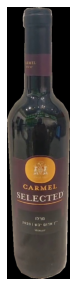

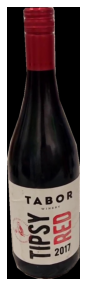

In [61]:
real_dir = data_dir + '/black_red2/7290008801157'
pred_dir = data_dir + '/black_red2/7290103681401'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

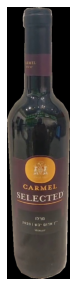

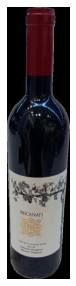

In [62]:
real_dir = data_dir + '/black_red2/7290008801157'
pred_dir = data_dir + '/black_red2/7290008670302'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

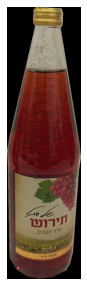

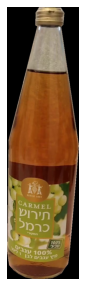

In [63]:
real_dir = data_dir + '/light_brown1/7290000024523'
pred_dir = data_dir + '/light_brown1/7290017812588'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

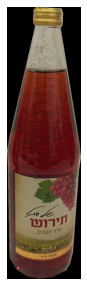

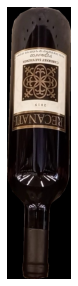

In [67]:
real_dir = data_dir + '/light_brown1/7290000024523'
pred_dir = data_dir + '/light_brown1/7290008670012'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

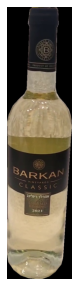

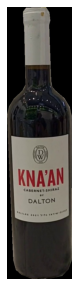

In [68]:
real_dir = data_dir + '/other/7290000023816'
pred_dir = data_dir + '/other/7290004494919'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

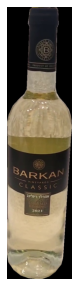

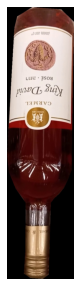

In [69]:
real_dir = data_dir + '/other/7290000023816'
pred_dir = data_dir + '/other/7290018294000'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

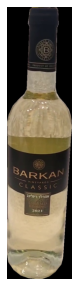

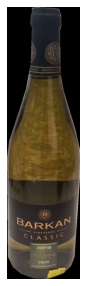

In [70]:
real_dir = data_dir + '/other/7290000023816'
pred_dir = data_dir + '/other/7290000023847'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))